In [197]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Base path for datasets
data_path = "data"

# Load data
receivals = pd.read_csv(f"{data_path}/kernel/receivals.csv")
purchase_orders = pd.read_csv(f"{data_path}/kernel/purchase_orders.csv")
materials = pd.read_csv(f"{data_path}/extended/materials.csv")
transportation = pd.read_csv(f"{data_path}/extended/transportation.csv")

# Convert date columns to datetime
receivals["date_arrival"] = pd.to_datetime(receivals["date_arrival"], utc=True)
purchase_orders["delivery_date"] = pd.to_datetime(purchase_orders["delivery_date"], utc=True)
purchase_orders["created_date_time"] = pd.to_datetime(purchase_orders["created_date_time"], utc=True)
purchase_orders["modified_date_time"] = pd.to_datetime(purchase_orders["modified_date_time"], utc=True)

## How the data was generated

### Receivals key uniqueness

In [223]:
recv = receivals.copy()         

key_sets = [
    ["purchase_order_id", "purchase_order_item_no", "receival_item_no"],
    ["batch_id", "receival_item_no"]
]
for keys in key_sets:
    dup = recv.groupby(keys).size().gt(1).sum()
    total = recv.groupby(keys).ngroups
    print(f"{keys}: {dup} duplicate groups of {total} total ({dup/total:.2%} duplicates)")
    

['purchase_order_id', 'purchase_order_item_no', 'receival_item_no']: 18502 duplicate groups of 35680 total (51.86% duplicates)
['batch_id', 'receival_item_no']: 0 duplicate groups of 64765 total (0.00% duplicates)


Receival_item_no is not unique within a purchase order item. It likely resets per batch, or is reused when a purchase order item is split across batches/lines.

The pair [batch_id, receival_item_no] is unique. So receival_item_no seems to be scoped to the batch, not to the purchase order item. Use [batch_id, receival_item_no] as the primary key when aggregating or joining receivals.

In [225]:
keys_bad = ["purchase_order_id","purchase_order_item_no","receival_item_no"]
dups = recv[recv.duplicated(keys_bad, keep=False)] \
        .sort_values(keys_bad)
cols = keys_bad + ["batch_id","date_arrival","rm_id","product_id","net_weight","receival_status"]
dups[cols].head(20)

,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,rm_id,product_id,net_weight,receival_status
41186,363.0,30.0,1.0,NaN,2012-07-06 13:01:00+00:00,2182.0,91901201.0,2380.0,Completed
41257,363.0,30.0,1.0,NaN,2012-07-12 12:36:00+00:00,2182.0,91901201.0,9160.0,Completed
416,206172.0,10.0,1.0,NaN,2004-07-19 08:36:00+00:00,367.0,91900143.0,11560.0,Completed
1191,206172.0,10.0,1.0,NaN,2004-10-13 06:47:00+00:00,365.0,91900143.0,25440.0,Completed
1414,206172.0,10.0,1.0,NaN,2004-10-28 15:25:00+00:00,365.0,91900143.0,18720.0,Completed
1996,206172.0,10.0,1.0,NaN,2004-12-12 23:22:00+00:00,365.0,91900143.0,17980.0,Completed
417,206172.0,20.0,2.0,NaN,2004-07-19 08:36:00+00:00,375.0,91900302.0,6900.0,Completed
1997,206172.0,20.0,2.0,NaN,2004-12-12 23:22:00+00:00,375.0,91900302.0,8340.0,Completed
2,208490.0,10.0,1.0,NaN,2004-06-15 11:38:00+00:00,365.0,91900143.0,11281.0,Completed
41,208490.0,10.0,1.0,NaN,2004-06-17 09:11:00+00:00,365.0,91900143.0,6287.0,Completed


Looking at sample rows, those duplicates have different arrival dates and/or different net weights. In other words, they’re partial deliveries for the same purchase order line, not accidental double entries.

Aggregate daily totals by the calendar day of date_arrival and by a material identifier (rm_id or product_id).
For a unique receival key, prefer [batch_id, receival_item_no]. If batch_id is missing, use [purchase_order_id, purchase_order_item_no, receival_item_no, date_arrival], and append a within-group sequence if duplicates remain.

### Link receivals and purchase orders

In [233]:
recv2 = receivals.copy()
po = purchase_orders.copy()    

join_cols = ["purchase_order_id", "purchase_order_item_no"]
merged = recv2.merge(po[join_cols + ["quantity","delivery_date"]], on=join_cols, how="left")

tot   = len(merged)
unmatched = merged["quantity"].isna().sum()
matched   = tot - unmatched

print(f"Matched:   {matched:,}")
print(f"Unmatched: {unmatched:,}")
print(f"Total:     {tot:,}")

Matched:   122,537
Unmatched: 56
Total:     122,593


56 receival rows is not linked to a purchase order line.

### Planned vs actual delivery lag

In [235]:
recv3 = receivals.copy()
po2 = purchase_orders.copy()    

lag_df = recv3.merge(po2[join_cols + ["delivery_date"]], on=join_cols, how="left")
lag = (lag_df["date_arrival"] - lag_df["delivery_date"]).dt.days.dropna()
if len(lag):
    print(f"Count={len(lag):,}, Median={lag.median():.1f}, p25={lag.quantile(0.25):.1f}, p75={lag.quantile(0.75):.1f}, p95={lag.quantile(0.95):.1f}")
    print(f"Late={100*(lag>0).mean():.1f}%, Early={100*(lag<0).mean():.1f}%, On-time={100*(lag==0).mean():.1f}%")
else:
    print("Not enough valid dates.")

Count=122,537, Median=-15.0, p25=-26.0, p75=-4.0, p95=9.0
Late=8.1%, Early=88.9%, On-time=3.0%


The majority of the arrival date beat the expected date by 1–4 weeks, and very few land exactly on it.
Late receipts are a minority (≈8%), and the late tail isn’t big (95% are ≤9 days late).

If you use delivery_date for service-level KPIs, consider classifying anything within a negative window (e.g., up to 2 weeks early) as on-time, or recalibrating targets by supplier/material so the metric reflects reality.

### Purchase order date quality

In [246]:
po3 = purchase_orders.copy()  

month_end = po3["delivery_date"].dt.is_month_end.mean()
print(f"delivery_date at month-end (placeholder risk): {month_end:.1%}")

ok = (po3["modified_date_time"] >= po3["created_date_time"]).mean()
print(f"modified_date_time ≥ created_date_time: {ok:.1%}")

# only rows were both dates exist
valid = po3["modified_date_time"].notna() & po3["created_date_time"].notna()

ok_count   = (po3.loc[valid, "modified_date_time"] >= po3.loc[valid, "created_date_time"]).sum()
total_val  = valid.sum()
bad_count  = total_val - ok_count         
missing    = len(po3) - total_val            

print(f"Modified ≥ created): {ok_count:,} av {total_val:,} "
      f"({ok_count/total_val:.1%})")
print(f"Modified < created): {bad_count:,}")
print(f"Missing dates: {missing:,}")

delivery_date at month-end (placeholder risk): 0.5%
modified_date_time ≥ created_date_time: 98.5%
Modified ≥ created): 32,679 av 32,679 (100.0%)
Modified < created): 0
Missing dates: 492


We flagged delivery dates that fall exactly on the last day of a month—a common placeholder when someone doesn’t know the real date. Only 0.5% of purchase order lines have a month-end date, so the risk of placeholder delivery dates is very low.

The audit trail is internally consistent wherever timestamps are present. The only quality gap is coverage, some purchase orders don’t have both timestamps. Cleaning or backfilling those 492 records would likely lift the overall pass rate from 98.5% to 100%.

## Explore individual features

In [204]:
def preview_feature_summary(df, name, top_n=20):

    print(f"\n[{name}] feature summary")
    print("-" * (len(name) + 20))
    
    rows = []
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        info = {
            "column": c,
            "dtype": dtype,
            "non_null%": (1 - s.isna().mean()) * 100,
            "nunique": s.nunique(dropna=True)
        }

        # Handle numeric
        if pd.api.types.is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            info.update(dict(
                min=np.nanmin(x), 
                q25=np.nanquantile(x, .25), 
                median=np.nanquantile(x, .5),
                q75=np.nanquantile(x, .75), 
                max=np.nanmax(x), 
                mean=np.nanmean(x),
                std=np.nanstd(x), 
                skew=pd.Series(x).skew(skipna=True)
            ))

        # Handle datetimes
        elif pd.api.types.is_datetime64_any_dtype(s):
            info.update(dict(
                min_ts=s.min(), 
                max_ts=s.max()))

        # Treat everything else as categorical/text
        else:
            ex = s.dropna().astype(str).unique()[:5]
            info["examples"] = ", ".join(ex)

        rows.append(info)

    table = pd.DataFrame(rows)
    print(table.head(top_n).to_string(index=False))
    return table

### Receivals

In [207]:
summary_recv = preview_feature_summary(recv, "Receivals", top_n=30)


[Receivals] feature summary
-----------------------------
                column               dtype  non_null%  nunique     min        q25     median        q75        max         mean          std       skew                    min_ts                    max_ts                                                examples
                 rm_id             float64  99.951058      203   342.0     1906.0     2130.0     2160.0     4501.0 2.151939e+03 5.082164e+02   0.461632                       NaT                       NaT                                                     NaN
            product_id             float64  99.951058       54  1002.0 91900143.0 91900143.0 91900302.0 91902090.0 9.137382e+07 6.935938e+06 -13.098030                       NaT                       NaT                                                     NaN
     purchase_order_id             float64  99.954320     7173   363.0   236857.0   272803.0   300251.0   331105.0 2.703605e+05 3.535135e+04  -0.099933          

Half of the rows have no batch; don’t rely on batch_id alone as a key. Net_weight has a minimum value of 0.0 (meaning some rows are missing), skew is around +0.07, which is nearly symmetric. 

Missing net_weight: 70 / 122,593 
IQR outliers: 10 / 122,593  (q1=5660.0, q3=21120.0, lo=-2070.0, hi=28850.0)
Extreme net_weight > p99.5: 594


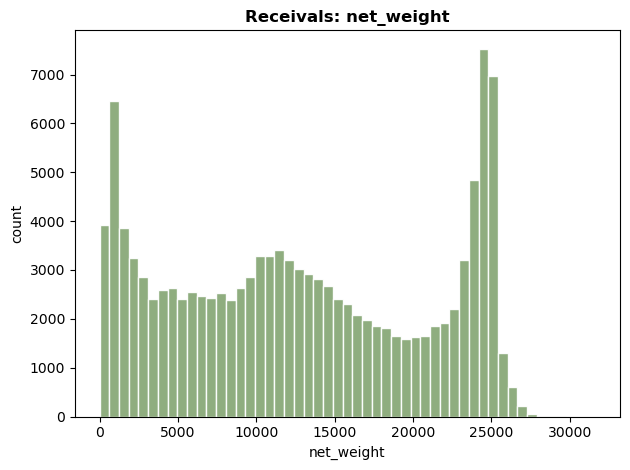

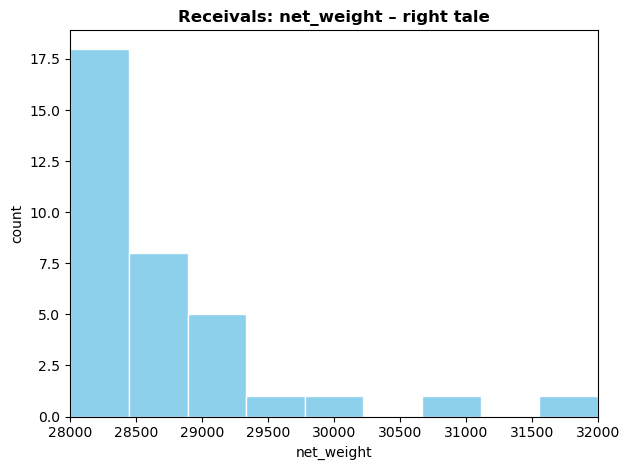

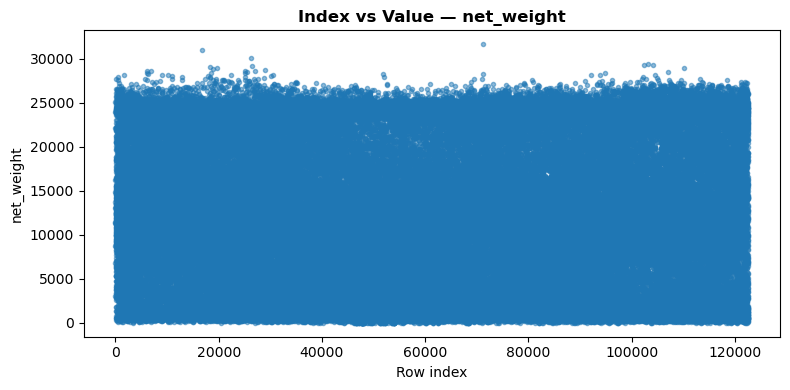

In [ ]:
recv4 = receivals.copy()

# missing net_weight
miss = recv4['net_weight'].isna().sum()
print(f"Missing net_weight: {miss:,} / {len(recv4):,} ")

# outliers
x = recv4["net_weight"]
q1, q3 = x.quantile([.25, .75])
iqr = q3 - q1
lo, hi = q1 - 0.5*iqr, q3 + 0.5*iqr  # at 0.75*iqr there were 0 outliers

mask_iqr = (x < lo) | (x > hi)           
print(f"IQR outliers: {mask_iqr.sum():,} / {len(recv4):,}  (q1={q1:.1f}, q3={q3:.1f}, lo={lo:.1f}, hi={hi:.1f})")

quantile = int((x > x.quantile(.995)).sum())
print(f"Extreme net_weight > p99.5: {quantile}")

# histogram
y = pd.to_numeric(x, errors="coerce")
plt.figure()
#plt.hist(x, bins=60)
plt.hist(
    y,
    bins="fd",                 
    color="#89a978",           
    edgecolor="white",         
    alpha=0.95
)
plt.title("Receivals: net_weight", weight="bold")
plt.xlabel("net_weight")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(
    y,
    bins="fd",
    color="#87CEEB",
    edgecolor="white",
    alpha=0.95,
    range=(28000, 32000)     
)
plt.xlim(28000, 32000)
plt.title("Receivals: net_weight – right tale", weight="bold")
plt.xlabel("net_weight")
plt.ylabel("count")
plt.tight_layout()
plt.show()

x = receivals["net_weight"]

plt.figure(figsize=(8,4))
plt.plot(x, '.', alpha=0.5)
plt.title("Index vs Value — net_weight", weight = "bold")
plt.xlabel("Row index")
plt.ylabel("net_weight")
plt.tight_layout()
plt.show()

Should exclude missing net_weights exclude when summing. Large peak around 2000 and 24000/25000. The distribution is bimodal.
Outliers: a short right tail up to around 29k, few extreme values. With 0.5×IQR fences, hi = q3 + 0.5·IQR ≈ 21,110 + 7,730 ≈ 28,840, only 10 outliers over that.

There’s no visible trend or step-change across the index: the cloud looks the same from row 0 to row 120k. That means nothing suspicious about file ordering (no block of weird zeros, no sudden shift).
A few very small weights exist, but they’re rare, no huge spikes beyond ~30k.

####  date_arrival, receival_status, rm_id and supplier_id

min  2004-06-15 11:34:00+00:00 | max = 2024-12-19 13:36:00+00:00
Rows with date = 122,593 / 122,593

Receival status distribution
------------------------------------------------
Completed             122448
Finished unloading       106
Start unloading           32
Planned                    4
(NA)                       3


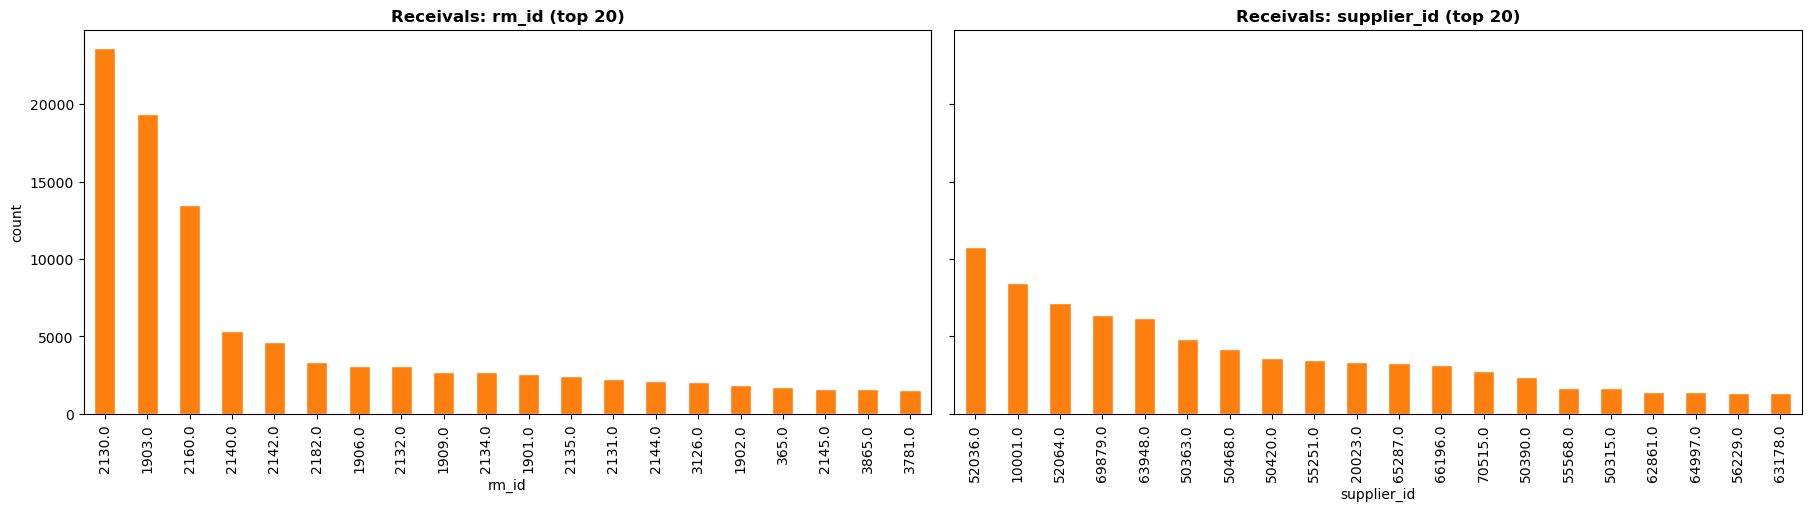

In [296]:
recv5 = receivals.copy()
import shutil

ds = recv5["date_arrival"]
if len(ds):
    print(f"min  {ds.min()} | max = {ds.max()}")
    print(f"Rows with date = {len(ds):,} / {len(recv):,}")

n = "Receival status distribution"
print(f"\n{n}")
print("-" * (len(n) + 20))
rs = recv["receival_status"]
vc = rs.astype("object").fillna("(NA)").value_counts()
print(vc.to_string())

rm = recv5["rm_id"].astype("object").fillna("(NA)").value_counts().head(20)
sp = recv5["supplier_id"].astype("object").fillna("(NA)").value_counts().head(20)

fig, axs = plt.subplots(1, 2, figsize=(18, 5), constrained_layout=True, sharey=True)

rm.plot(kind="bar", ax=axs[0], color="#ff7f0e", edgecolor="white")
axs[0].set_title("Receivals: rm_id (top 20)", weight="bold")
axs[0].set_xlabel("rm_id")
axs[0].set_ylabel("count")
axs[0].tick_params(axis="x", labelrotation=90)

sp.plot(kind="bar", ax=axs[1], color="#ff7f0e", edgecolor="white")
axs[1].set_title("Receivals: supplier_id (top 20)", weight="bold")
axs[1].set_xlabel("supplier_id")
axs[1].tick_params(axis="x", labelrotation=90)

plt.show()

### Purchase orders

In [210]:
prof_po = preview_feature_summary(po, "purchase_orders")


[purchase_orders] feature summary
-----------------------------------
                column               dtype  non_null%  nunique     min        q25     median        q75        max         mean          std      skew                    min_ts                    max_ts              examples
     purchase_order_id               int64 100.000000     8135     1.0   231474.0   257579.0   289944.0   331202.0 2.629573e+05 3.410719e+04 -0.256631                       NaT                       NaT                   NaN
purchase_order_item_no               int64 100.000000       94     1.0       20.0       60.0      200.0      930.0 1.346447e+02 1.608383e+02  1.652625                       NaT                       NaT                   NaN
              quantity             float64 100.000000     4997 -8580.0    10000.0    26280.0   100000.0 24975988.0 9.031416e+04 3.308047e+05 32.728669                       NaT                       NaT                   NaN
         delivery_date dateti

Quantities: handle negative and extreme values, confirm business meaning (returns, cancellations, corrections).

Both KG and PUND is used, should standardize to KG before linking to receivals/weights.

Filters for analyses: typically restrict to status in {"Open","Closed"} and positive quantities unless you’re explicitly analyzing corrections.

#### Quantity

Rows: 33,171
Q1=10000, Q3=100000, IQR=90000  |  cutoffs: hi=156120
Negatives: 6
Zeros: 4
IQR outliers: 5,709


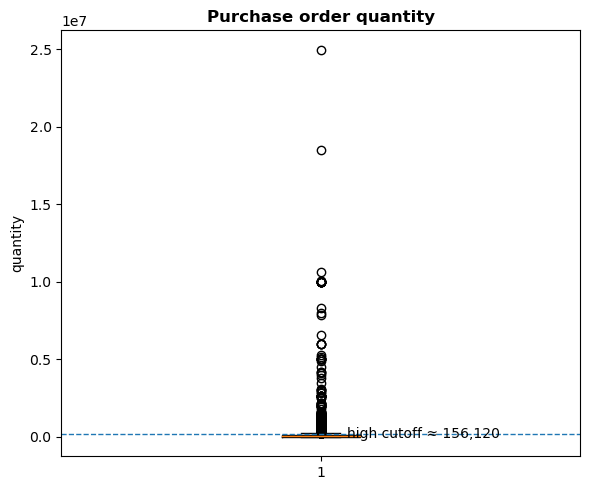

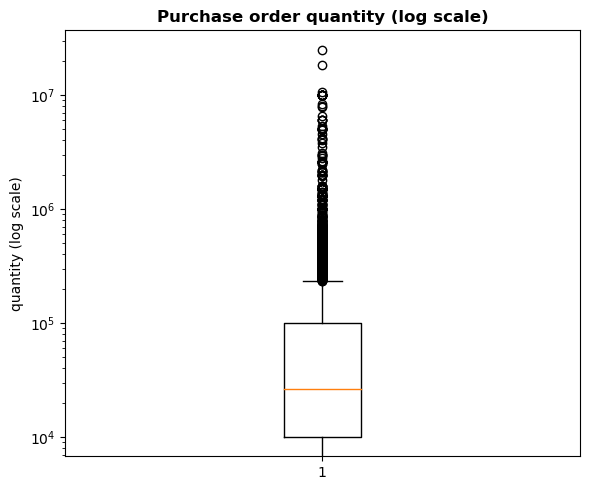

In [305]:
po4 = purchase_orders.copy()

suspect = []
neg_mask   = po4["quantity"] < 0
zero_mask  = (po4["quantity"] == 0)

quantity = po4["quantity"]
Q1, Q3 = quantity.quantile([.25, .75])
IQR = Q3 - Q1
high = q3 + 1.5*IQR 
iqr_mask  = (po4["quantity"] > high)

suspect.extend([neg_mask, zero_mask, iqr_mask])

print(f"Rows: {len(po4):,}")
print(f"Q1={Q1:.0f}, Q3={Q3:.0f}, IQR={IQR:.0f}  |  cutoffs: hi={high:.0f}")
print(f"Negatives: {neg_mask.sum():,}")
print(f"Zeros: {zero_mask.sum():,}")
print(f"IQR outliers: {iqr_mask.sum():,}")

plt.figure(figsize=(6, 5))
plt.boxplot(quantity, vert=True, showfliers=True)
plt.title("Purchase order quantity", weight="bold")
plt.ylabel("quantity")
plt.axhline(high, linestyle="--", linewidth=1)
plt.text(1.05, high, f"high cutoff ≈ {high:,.0f}", va="center")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.boxplot(quantity, vert=True, showfliers=True)
plt.yscale("log")
plt.title("Purchase order quantity (log scale)", weight="bold")
plt.ylabel("quantity (log scale)")
plt.tight_layout()
plt.show()

The “middle” 50% of orders sits between 10k and 100k units.

Negatives: 6 rows.

Zeros: 4 rows.

In [309]:
ds = po4["delivery_date"]
if len(ds):
    print(f"min  {ds.min()} | max = {ds.max()}")


min  2002-01-30 23:00:00+00:00 | max = 2025-06-29 22:00:00+00:00


Different coverage windows. The purchase order table goes back to 2002-01-30, while receivals start at 2004-06-15. If the warehouse/receivals system (or your extract) only has data from mid-2004 onward, any purchase order delivery dates before that will naturally have no matching receipts.

In [311]:
t = "Purchase order status"
print(f"\n{t}")
print("-" * (len(t) + 20))
status = po4["status"]
vc = status.astype("object").fillna("(NA)").value_counts()
print(vc.to_string())


Purchase order status
-----------------------------------------
Closed     28780
Deleted     3191
Open        1200


### Transportation and materials

In [313]:
mat = materials.copy()
trans = transportation.copy()
preview_feature_summary(mat, "materials")
preview_feature_summary(trans, "transportation", top_n=20)


[materials] feature summary
-----------------------------
                  column   dtype  non_null%  nunique    min        q25     median        q75        max         mean          std      skew                                                                                                                   examples
                   rm_id float64  99.917898      203  342.0     2133.0     2160.0     3125.0     4501.0 2.546417e+03 7.829615e+02 -0.193790                                                                                                                        NaN
              product_id float64  99.917898       54 1002.0 91900152.0 91900302.0 91901440.0 91902090.0 8.351876e+07 2.645826e+07 -2.843281                                                                                                                        NaN
         product_version float64  99.917898       65    1.0        5.0       13.0       25.0       68.0 1.642071e+01 1.318245e+01  0.942982             

,column,dtype,non_null%,nunique,min,q25,median,q75,max,mean,std,skew,examples
0,rm_id,float64,99.953504,203,342.0,1906.0,2130.0,2160.0,4501.0,2.151939e+03,5.082164e+02,0.461632,NaN
1,product_id,float64,99.953504,54,1002.0,91900143.0,91900143.0,91900302.0,91902090.0,9.137382e+07,6.935938e+06,-13.098030,NaN
2,purchase_order_id,float64,99.956766,7173,363.0,236857.0,272803.0,300251.0,331105.0,2.703605e+05,3.535135e+04,-0.099933,NaN
3,purchase_order_item_no,float64,99.956766,92,10.0,10.0,40.0,150.0,930.0,1.019654e+02,1.301033e+02,2.025080,NaN
4,receival_item_no,int64,100.000000,15,0.0,1.0,1.0,2.0,14.0,1.448161e+00,8.467539e-01,2.427058,NaN
5,batch_id,float64,52.830573,64765,43903.0,746268.0,892069.0,1041403.0,1178438.0,8.898592e+05,1.719868e+05,-0.075880,NaN
6,transporter_name,object,100.000000,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transporter0, Transporter1, Transporter2, Tran..."
7,vehicle_no,object,100.000000,17029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Vehicle0, Vehicle1, Vehicle2, Vehicle3, Vehicle4"
8,unit_status,object,99.993474,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transferred, Accepted, Pending, Rejected, Canc..."
9,vehicle_start_weight,float64,99.983685,2204,698.0,30460.0,35560.0,39720.0,60720.0,3.457273e+04,5.733303e+03,-0.807551,NaN


### Weight over months

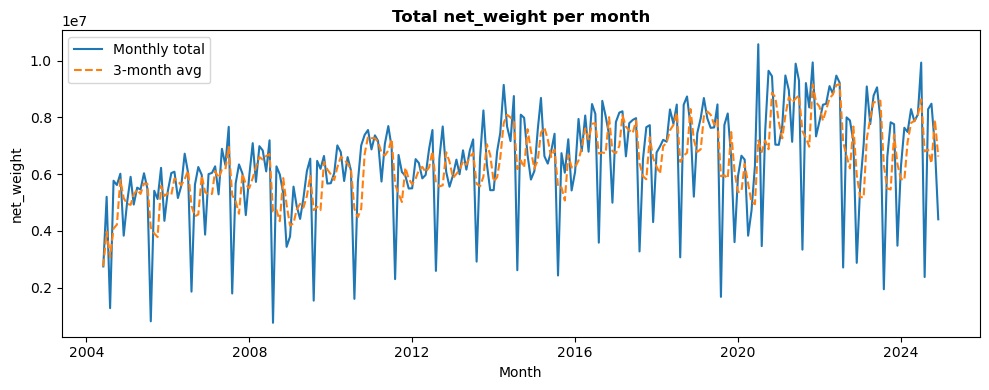

In [322]:
df = receivals.copy()
df["date_arrival"] = pd.to_datetime(df["date_arrival"], utc=True, errors="coerce")
df["net_weight"]   = pd.to_numeric(df["net_weight"], errors="coerce")

monthly = (
    df.set_index("date_arrival")
      .resample("MS")["net_weight"]
      .sum(min_count=1)
)

roll3 = monthly.rolling(3, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values, label="Monthly total")
plt.plot(roll3.index, roll3.values, linestyle="--", label="3-month avg")
plt.title("Total net_weight per month", weight = "bold")
plt.xlabel("Month")
plt.ylabel("net_weight")
plt.legend()
plt.tight_layout()
plt.show()

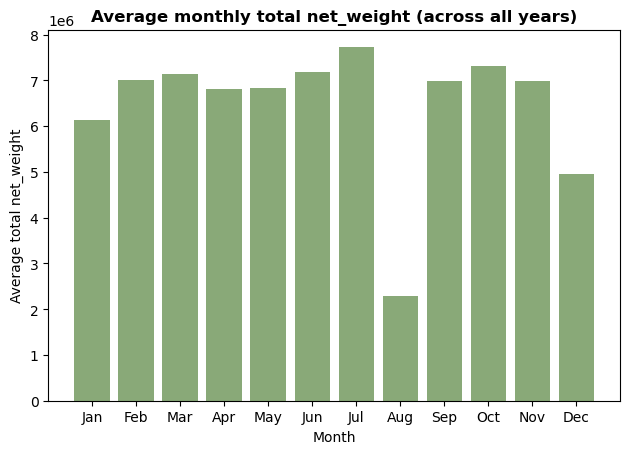

In [327]:
m = receivals.copy()
m["date_arrival"] = pd.to_datetime(m["date_arrival"], utc=True, errors="coerce")
m["net_weight"] = pd.to_numeric(m["net_weight"], errors="coerce")

by_moy_avg = (
    m.set_index("date_arrival")["net_weight"]
     .resample("MS").sum()
     .groupby(lambda d: d.month).mean()
     .reindex(range(1,13))
)

month_names = [pd.Timestamp(2000, m, 1).strftime("%b") for m in range(1,13)]
plt.bar(month_names, by_moy_avg.values, color="#89a978")
plt.title("Average monthly total net_weight (across all years)", weight = "bold")
plt.xlabel("Month"); plt.ylabel("Average total net_weight")
plt.tight_layout(); plt.show()